# CNN for Particle Classification

In this notebook, we train 10 layers deep CNN for particle type classification ($e^-$, $\mu^-$, and $\gamma$) using the workshop dataset.

In [1]:
from __future__ import print_function
from IPython.display import display
import torch, time
import numpy as np

In [2]:
from models import resnet

In [3]:
resnet.__file__

'models/resnet.py'

In [4]:
help(resnet)

Help on module models.resnet in models:

NAME
    models.resnet

FILE
    /data/wfedorko/UVicWorkshopPlayground_WF/B/notebooks/models/resnet.py

CLASSES
    torch.nn.modules.module.Module(__builtin__.object)
        ResNet
    
    class ResNet(torch.nn.modules.module.Module)
     |  Method resolution order:
     |      ResNet
     |      torch.nn.modules.module.Module
     |      __builtin__.object
     |  
     |  Methods defined here:
     |  
     |  __init__(self, block, layers, num_input_channels=2, num_classes=1000, zero_init_residual=False)
     |  
     |  forward(self, x)
     |  
     |  ----------------------------------------------------------------------
     |  Methods inherited from torch.nn.modules.module.Module:
     |  
     |  __call__(self, *input, **kwargs)
     |  
     |  __delattr__(self, name)
     |  
     |  __dir__(self)
     |  
     |  __getattr__(self, name)
     |  
     |  __repr__(self)
     |  
     |  __setattr__(self, name, value)
     |  
     |  

## Defining a network
Let's define our network. The design below consists of 7 convolution layers + 3 fully-connected layers (10 learnable layers). Here is a summary of the graph operations.
* Feature extractor:
    1. Input shape: (N,88,168,2) ... N samples of 88x168 2D images with 2 channels
    2. Convolution layer + ReLU, 16 filters, kernel size 3x3, stride 1 (default)
    3. 2D max-pooling, kernel size 2, stride 2
    4. 2x Convolution layer + ReLU, 32 filters, kernel size 3x3, stride 1 (default)
    5. 2D max-pooling, kernel size 2, stride 2
    6. 2x Convolution layer + ReLU, 64 filters, kernel size 3x3, stride 1 (default)
    7. 2D max-pooling, kernel size 2, stride 2
    8. 2x Convolution layer + ReLU, 128 filters, kernel size 3x3, stride 1 (default)
* Flattening
    9. 2D average-pooling, kernel size = 2D image spatial dimension at this point (results in length 128 1D array)
* Classifier:
    10. Fully-connected layer + ReLU, 128 filters
    11. Fully-connected layer + ReLU, 128 filters
    12. Fully-connected layer, M filters where M = number of classification categories

class CNN(torch.nn.Module):
    
    def __init__(self, num_class):
        
        super(CNN, self).__init__()
        # feature extractor CNN
        self._feature = torch.nn.Sequential(
            torch.nn.Conv2d(2,16,3), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(16,32,3), torch.nn.ReLU(),
            torch.nn.Conv2d(32,32,3), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(32,64,3), torch.nn.ReLU(),
            torch.nn.Conv2d(64,64,3), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(64,128,3), torch.nn.ReLU(),
            torch.nn.Conv2d(128,128,3), torch.nn.ReLU())
        self._classifier = torch.nn.Sequential(
            torch.nn.Linear(128,128), torch.nn.ReLU(),
            torch.nn.Linear(128,128), torch.nn.ReLU(),
            torch.nn.Linear(128,num_class)
        )

    def forward(self, x):
        net = self._feature(x)
        net = torch.nn.AvgPool2d(net.size()[2:])(net)
        return self._classifier(net.view(-1,128))


## Defining a train loop
For convenience, define a _BLOB_ class to keep objects together. To a BLOB instance, we attach LeNet, our loss function (`nn.CrossEntropyLoss`), and Adam optimizer algorithm. For analysis purpose, we also include `nn.Softmax`. Finally, we attach data and label place holders.

In [5]:
class BLOB:
    pass
blob=BLOB()
blob.net       = resnet.resnet50(num_classes=3).cuda() #CNN(3).cuda() # construct Lenet for 3 class classification, use GPU
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

We define 2 functions to be called in the training loop: forward and backward. These functions implement the evaluation of the results, error (loss) definition, and propagation of errors (gradients) back to update the network parameters.

In [6]:
def forward(blob,train=True):
    """
       Args: blob should have attributes, net, criterion, softmax, data, label
       Returns: a dictionary of predicted labels, softmax, loss, and accuracy
    """
    with torch.set_grad_enabled(train):
        # Prediction
        data = torch.as_tensor(blob.data).cuda()#[torch.as_tensor(d).cuda() for d in blob.data]
        #print("this is the data size before permuting: {}".format(data.size()))
        data = data.permute(0,3,1,2)
        #print("this is the data size after permuting: {}".format(data.size()))
        prediction = blob.net(data)
        # Training
        loss,acc=-1,-1
        if blob.label is not None:
            label = torch.as_tensor(blob.label).type(torch.LongTensor).cuda()#[torch.as_tensor(l).cuda() for l in blob.label]
            label.requires_grad = False
            loss = blob.criterion(prediction,label)
        blob.loss = loss
        
        softmax    = blob.softmax(prediction).cpu().detach().numpy()
        prediction = torch.argmax(prediction,dim=-1)
        accuracy   = (prediction == label).sum().item() / float(prediction.nelement())        
        prediction = prediction.cpu().detach().numpy()
        
        return {'prediction' : prediction,
                'softmax'    : softmax,
                'loss'       : loss.cpu().detach().item(),
                'accuracy'   : accuracy}

def backward(blob):
    blob.optimizer.zero_grad()  # Reset gradients accumulation
    blob.loss.backward()
    blob.optimizer.step()


## Running a train loop 
Let's prepare the data loaders for both train and test datasets. We use the latter to check if the network suffers from overtraining.

In [7]:
# Create data loader
from iotools import loader_factory
DATA_DIRS=['/data/hkml_data/IWCDgrid/varyE/e-','/data/hkml_data/IWCDgrid/varyE/mu-','/data/hkml_data/IWCDgrid/varyE/gamma']
# for train
train_loader=loader_factory('H5Dataset', batch_size=64, shuffle=True, num_workers=4, data_dirs=DATA_DIRS, flavour='1M.h5', start_fraction=0.0, use_fraction=0.8)
# for validation
val_loader=loader_factory('H5Dataset', batch_size=1000, shuffle=True, num_workers=2, data_dirs=DATA_DIRS, flavour='1M.h5', start_fraction=0.8, use_fraction=0.1)
# for final analysis
test_loader=loader_factory('H5Dataset', batch_size=1024, shuffle=True, num_workers=2, data_dirs=DATA_DIRS, flavour='1M.h5', read_keys=['energies'], start_fraction=0.9, use_fraction=0.1)

I found the following files: ['/data/hkml_data/IWCDgrid/varyE/e-/IWCDgrid_varyE_e-_R0cm_20-2000MeV_1M.h5', '/data/hkml_data/IWCDgrid/varyE/mu-/IWCDgrid_varyE_mu-_R0cm_20-2000MeV_1M.h5', '/data/hkml_data/IWCDgrid/varyE/gamma/IWCDgrid_varyE_gamma_R0cm_20-2000MeV_1M.h5']
I found the following files: ['/data/hkml_data/IWCDgrid/varyE/e-/IWCDgrid_varyE_e-_R0cm_20-2000MeV_1M.h5', '/data/hkml_data/IWCDgrid/varyE/mu-/IWCDgrid_varyE_mu-_R0cm_20-2000MeV_1M.h5', '/data/hkml_data/IWCDgrid/varyE/gamma/IWCDgrid_varyE_gamma_R0cm_20-2000MeV_1M.h5']
I found the following files: ['/data/hkml_data/IWCDgrid/varyE/e-/IWCDgrid_varyE_e-_R0cm_20-2000MeV_1M.h5', '/data/hkml_data/IWCDgrid/varyE/mu-/IWCDgrid_varyE_mu-_R0cm_20-2000MeV_1M.h5', '/data/hkml_data/IWCDgrid/varyE/gamma/IWCDgrid_varyE_gamma_R0cm_20-2000MeV_1M.h5']


Also import `CSVData` from our utility module, which lets us write train log (accuracy, loss, etc.) in a csv file.

In [7]:
# %rm log_train.csv log_val.csv

In [8]:
# Import 0) progress bar and 1) data recording utility (into csv file)
from utils import progress_bar, CSVData, disp_learn_hist, disp_train_smoothed


In [9]:
blob.train_log, blob.val_log = CSVData('log_train.csv'), CSVData('log_val.csv')

In [10]:
!date

Wed Apr 17 11:21:45 UTC 2019


In [11]:
def save_state(blob, prefix='./snapshot'):
    # Output file name
    #filename = '%s-%d.ckpt' % (prefix, blob.iteration)
    filename = '%s.ckpt' % (prefix)
    
    # Save parameters
    # 0+1) iteration counter + optimizer state => in case we want to "continue training" later
    # 2) network weight
    torch.save({
        'global_step': blob.iteration,
        'optimizer': blob.optimizer.state_dict(),
        'state_dict': blob.net.state_dict()
        }, filename)
    return filename

def restore_state(weight_file, blob):
    # Open a file in read-binary mode
    with open(weight_file, 'rb') as f:
        # torch interprets the file, then we can access using string keys
        checkpoint = torch.load(f)
        # load network weights
        blob.net.load_state_dict(checkpoint['state_dict'], strict=False)
        # if optimizer is provided, load the state of the optimizer
        if blob.optimizer is not None:
            blob.optimizer.load_state_dict(checkpoint['optimizer'])
        # load iteration count
        blob.iteration = checkpoint['global_step']

Finally, we're ready to run the training! Let's create a dataloader, write a loop to  call forward and backward.

In [12]:
#restore_state("snapshot-78600.ckpt",blob)

In [13]:
blob.iteration=None
#blob.best_val_loss=0.289653033018

In [14]:
# Define train period. "epoch" = N image consumption where N is the total number of train samples.
TRAIN_EPOCH=30.0
# Set the network to training mode
blob.net.train()
if blob.iteration is not None and blob.iteration!=0:
    iteration=blob.iteration
    epoch=iteration/len(train_loader)
    best_val_loss=blob.best_val_loss
    print("re-starting")
else:
    epoch=0.
    iteration=0
    best_val_loss=1.0e6
    
# Start training


while int(epoch+0.5) < TRAIN_EPOCH:
    print('Epoch',int(epoch+0.5),'Starting @',time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    # Create a progress bar for this epoch
    from utils import progress_bar
    progress = display(progress_bar(0,len(train_loader)),display_id=True)
    # Loop over data samples and into the network forward function
    for i,data in enumerate(train_loader):
        # Data and label
        blob.data,blob.label = data[0:2]
        
        
        #if i==0:
        #    print("the labels are:")
        #    print(blob.label)
        # Call forward: make a prediction & measure the average error
        res = forward(blob,True)
        # Call backward: backpropagate error and update weights
        backward(blob)
        # Epoch update
        epoch += 1./len(train_loader)
        iteration += 1
        blob.iteration=iteration
        #
        # Log/Report
        #
        # Record the current performance on train set
        blob.train_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
        blob.train_log.write()
        # once in a while, report
        if i==0 or (i+1)%10 == 0:
            message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
            progress.update(progress_bar((i+1),len(train_loader),message))
        # more rarely, run validation
        if (i+1)%100 == 0:
            with torch.no_grad():
                blob.net.eval()
                val_data = next(iter(val_loader))
                blob.data,blob.label = val_data[0:2]
                res = forward(blob,False)
                blob.val_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
                blob.val_log.write()
                blob.val_log.flush()
                print("VAL set results: iteration: {}, epoch: {}, accuracy: {}, loss: {}".format(iteration,epoch,res['accuracy'],res['loss']))
                save_state(blob)
                if res['loss']<best_val_loss:
                    print('best validation loss so far!')
                    best_val_loss=res['loss']
                    blob.best_val_loss=best_val_loss
                    save_state(blob,'./snapshot_best_{}'.format(blob.iteration))
                
                
            blob.net.train()
        if epoch >= TRAIN_EPOCH:
            break
    message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
    progress.update(progress_bar((i+1),len(train_loader),message))

blob.val_log.close()
blob.train_log.close()

Epoch 0 Starting @ 2019-04-17 11:21:58


VAL set results: iteration: 100, epoch: 0.00266666666667, accuracy: 0.659, loss: 0.615955531597
best validation loss so far!
VAL set results: iteration: 200, epoch: 0.00533333333333, accuracy: 0.693, loss: 1.10912883282
VAL set results: iteration: 300, epoch: 0.008, accuracy: 0.741, loss: 0.494666337967
best validation loss so far!
VAL set results: iteration: 400, epoch: 0.0106666666667, accuracy: 0.71, loss: 0.518910288811
VAL set results: iteration: 500, epoch: 0.0133333333333, accuracy: 0.747, loss: 0.449319630861
best validation loss so far!
VAL set results: iteration: 600, epoch: 0.016, accuracy: 0.758, loss: 0.42426648736
best validation loss so far!
VAL set results: iteration: 700, epoch: 0.0186666666667, accuracy: 0.693, loss: 0.492981284857
VAL set results: iteration: 800, epoch: 0.0213333333333, accuracy: 0.774, loss: 0.426484942436
VAL set results: iteration: 900, epoch: 0.024, accuracy: 0.764, loss: 0.44200655818
VAL set results: iteration: 1000, epoch: 0.0266666666667, acc

VAL set results: iteration: 8600, epoch: 0.229333333333, accuracy: 0.789, loss: 0.411208242178
VAL set results: iteration: 8700, epoch: 0.232, accuracy: 0.799, loss: 0.383476674557
VAL set results: iteration: 8800, epoch: 0.234666666667, accuracy: 0.834, loss: 0.349816977978
VAL set results: iteration: 8900, epoch: 0.237333333333, accuracy: 0.796, loss: 0.38800162077
VAL set results: iteration: 9000, epoch: 0.24, accuracy: 0.804, loss: 0.383671581745
VAL set results: iteration: 9100, epoch: 0.242666666667, accuracy: 0.78, loss: 0.452267378569
VAL set results: iteration: 9200, epoch: 0.245333333333, accuracy: 0.817, loss: 0.385084241629
VAL set results: iteration: 9300, epoch: 0.248, accuracy: 0.794, loss: 0.409857571125
VAL set results: iteration: 9400, epoch: 0.250666666667, accuracy: 0.801, loss: 0.391244977713
VAL set results: iteration: 9500, epoch: 0.253333333333, accuracy: 0.829, loss: 0.372547030449
VAL set results: iteration: 9600, epoch: 0.256, accuracy: 0.8, loss: 0.390554487

best validation loss so far!
VAL set results: iteration: 17500, epoch: 0.466666666667, accuracy: 0.818, loss: 0.358188956976
VAL set results: iteration: 17600, epoch: 0.469333333333, accuracy: 0.807, loss: 0.366063386202
VAL set results: iteration: 17700, epoch: 0.472, accuracy: 0.802, loss: 0.374730437994
VAL set results: iteration: 17800, epoch: 0.474666666667, accuracy: 0.791, loss: 0.383370012045
VAL set results: iteration: 17900, epoch: 0.477333333333, accuracy: 0.805, loss: 0.36331820488
VAL set results: iteration: 18000, epoch: 0.48, accuracy: 0.801, loss: 0.374914675951
VAL set results: iteration: 18100, epoch: 0.482666666667, accuracy: 0.827, loss: 0.358082681894
VAL set results: iteration: 18200, epoch: 0.485333333333, accuracy: 0.796, loss: 0.382976323366
VAL set results: iteration: 18300, epoch: 0.488, accuracy: 0.802, loss: 0.375420153141
VAL set results: iteration: 18400, epoch: 0.490666666667, accuracy: 0.762, loss: 0.420902401209
VAL set results: iteration: 18500, epoch

VAL set results: iteration: 26300, epoch: 0.701333333333, accuracy: 0.843, loss: 0.341599315405
VAL set results: iteration: 26400, epoch: 0.704, accuracy: 0.819, loss: 0.35755059123
VAL set results: iteration: 26500, epoch: 0.706666666666, accuracy: 0.816, loss: 0.372753530741
VAL set results: iteration: 26600, epoch: 0.709333333333, accuracy: 0.84, loss: 0.331860035658
VAL set results: iteration: 26700, epoch: 0.712, accuracy: 0.83, loss: 0.349315941334
VAL set results: iteration: 26800, epoch: 0.714666666666, accuracy: 0.813, loss: 0.365086913109
VAL set results: iteration: 26900, epoch: 0.717333333333, accuracy: 0.788, loss: 0.406185209751
VAL set results: iteration: 27000, epoch: 0.72, accuracy: 0.809, loss: 0.358440101147
VAL set results: iteration: 27100, epoch: 0.722666666666, accuracy: 0.845, loss: 0.32604688406
VAL set results: iteration: 27200, epoch: 0.725333333333, accuracy: 0.814, loss: 0.361037015915
VAL set results: iteration: 27300, epoch: 0.728, accuracy: 0.837, loss: 

VAL set results: iteration: 35000, epoch: 0.933333333333, accuracy: 0.838, loss: 0.34549036622
VAL set results: iteration: 35100, epoch: 0.935999999999, accuracy: 0.8, loss: 0.393370240927
VAL set results: iteration: 35200, epoch: 0.938666666666, accuracy: 0.835, loss: 0.337039679289
VAL set results: iteration: 35300, epoch: 0.941333333333, accuracy: 0.838, loss: 0.341762304306
VAL set results: iteration: 35400, epoch: 0.943999999999, accuracy: 0.84, loss: 0.328297197819
VAL set results: iteration: 35500, epoch: 0.946666666666, accuracy: 0.835, loss: 0.324824392796
VAL set results: iteration: 35600, epoch: 0.949333333333, accuracy: 0.85, loss: 0.330253720284
VAL set results: iteration: 35700, epoch: 0.951999999999, accuracy: 0.847, loss: 0.317403197289
VAL set results: iteration: 35800, epoch: 0.954666666666, accuracy: 0.828, loss: 0.360105901957
VAL set results: iteration: 35900, epoch: 0.957333333333, accuracy: 0.833, loss: 0.370604544878
VAL set results: iteration: 36000, epoch: 0.9

VAL set results: iteration: 37600, epoch: 1.00266666667, accuracy: 0.839, loss: 0.329246759415
VAL set results: iteration: 37700, epoch: 1.00533333333, accuracy: 0.823, loss: 0.365889847279
VAL set results: iteration: 37800, epoch: 1.008, accuracy: 0.822, loss: 0.35489115119
VAL set results: iteration: 37900, epoch: 1.01066666667, accuracy: 0.845, loss: 0.339921325445
VAL set results: iteration: 38000, epoch: 1.01333333333, accuracy: 0.834, loss: 0.3478089571
VAL set results: iteration: 38100, epoch: 1.016, accuracy: 0.825, loss: 0.355694055557
VAL set results: iteration: 38200, epoch: 1.01866666667, accuracy: 0.855, loss: 0.336698561907
VAL set results: iteration: 38300, epoch: 1.02133333333, accuracy: 0.8, loss: 0.461772948503
VAL set results: iteration: 38400, epoch: 1.024, accuracy: 0.792, loss: 0.428645402193
VAL set results: iteration: 38500, epoch: 1.02666666667, accuracy: 0.856, loss: 0.335679620504
VAL set results: iteration: 38600, epoch: 1.02933333333, accuracy: 0.832, loss:

VAL set results: iteration: 47600, epoch: 1.26933333333, accuracy: 0.83, loss: 0.345421940088
VAL set results: iteration: 47700, epoch: 1.272, accuracy: 0.835, loss: 0.340137302876
VAL set results: iteration: 47800, epoch: 1.27466666667, accuracy: 0.836, loss: 0.345318704844
VAL set results: iteration: 47900, epoch: 1.27733333333, accuracy: 0.82, loss: 0.368533968925
VAL set results: iteration: 48000, epoch: 1.28, accuracy: 0.834, loss: 0.333045274019
VAL set results: iteration: 48100, epoch: 1.28266666667, accuracy: 0.829, loss: 0.347335755825
VAL set results: iteration: 48200, epoch: 1.28533333333, accuracy: 0.859, loss: 0.331029444933
VAL set results: iteration: 48300, epoch: 1.288, accuracy: 0.822, loss: 0.367151737213
VAL set results: iteration: 48400, epoch: 1.29066666667, accuracy: 0.84, loss: 0.339789092541
VAL set results: iteration: 48500, epoch: 1.29333333333, accuracy: 0.832, loss: 0.362004369497
VAL set results: iteration: 48600, epoch: 1.296, accuracy: 0.829, loss: 0.3559

VAL set results: iteration: 56500, epoch: 1.50666666666, accuracy: 0.821, loss: 0.364096015692
VAL set results: iteration: 56600, epoch: 1.50933333333, accuracy: 0.87, loss: 0.292484641075
best validation loss so far!
VAL set results: iteration: 56700, epoch: 1.512, accuracy: 0.842, loss: 0.32328876853
VAL set results: iteration: 56800, epoch: 1.51466666666, accuracy: 0.862, loss: 0.335067540407
VAL set results: iteration: 56900, epoch: 1.51733333333, accuracy: 0.818, loss: 0.381804913282
VAL set results: iteration: 57000, epoch: 1.52, accuracy: 0.83, loss: 0.355084359646
VAL set results: iteration: 57100, epoch: 1.52266666666, accuracy: 0.82, loss: 0.362780719995
VAL set results: iteration: 57200, epoch: 1.52533333333, accuracy: 0.835, loss: 0.35198572278
VAL set results: iteration: 57300, epoch: 1.528, accuracy: 0.83, loss: 0.350147306919
VAL set results: iteration: 57400, epoch: 1.53066666666, accuracy: 0.839, loss: 0.334327042103
VAL set results: iteration: 57500, epoch: 1.53333333

VAL set results: iteration: 65400, epoch: 1.744, accuracy: 0.852, loss: 0.31552234292
VAL set results: iteration: 65500, epoch: 1.74666666666, accuracy: 0.853, loss: 0.320332229137
VAL set results: iteration: 65600, epoch: 1.74933333333, accuracy: 0.817, loss: 0.356665223837
VAL set results: iteration: 65700, epoch: 1.752, accuracy: 0.849, loss: 0.321420490742
VAL set results: iteration: 65800, epoch: 1.75466666666, accuracy: 0.835, loss: 0.342422127724
VAL set results: iteration: 65900, epoch: 1.75733333333, accuracy: 0.843, loss: 0.346536695957
VAL set results: iteration: 66000, epoch: 1.76, accuracy: 0.833, loss: 0.341002643108
VAL set results: iteration: 66100, epoch: 1.76266666666, accuracy: 0.852, loss: 0.308367520571
VAL set results: iteration: 66200, epoch: 1.76533333333, accuracy: 0.861, loss: 0.310696691275
VAL set results: iteration: 66300, epoch: 1.768, accuracy: 0.854, loss: 0.321905255318
VAL set results: iteration: 66400, epoch: 1.77066666666, accuracy: 0.827, loss: 0.33

VAL set results: iteration: 74400, epoch: 1.984, accuracy: 0.844, loss: 0.32539665699
VAL set results: iteration: 74500, epoch: 1.98666666666, accuracy: 0.843, loss: 0.339087456465
VAL set results: iteration: 74600, epoch: 1.98933333333, accuracy: 0.839, loss: 0.335916608572
VAL set results: iteration: 74700, epoch: 1.992, accuracy: 0.839, loss: 0.342051774263
VAL set results: iteration: 74800, epoch: 1.99466666666, accuracy: 0.841, loss: 0.354330986738
VAL set results: iteration: 74900, epoch: 1.99733333333, accuracy: 0.826, loss: 0.360859662294
VAL set results: iteration: 75000, epoch: 2.0, accuracy: 0.817, loss: 0.368349999189
Epoch 2 Starting @ 2019-04-17 14:24:01


VAL set results: iteration: 75100, epoch: 2.00266666666, accuracy: 0.825, loss: 0.354229062796
VAL set results: iteration: 75200, epoch: 2.00533333333, accuracy: 0.84, loss: 0.333644360304
VAL set results: iteration: 75300, epoch: 2.008, accuracy: 0.83, loss: 0.35054987669
VAL set results: iteration: 75400, epoch: 2.01066666666, accuracy: 0.834, loss: 0.348932862282
VAL set results: iteration: 75500, epoch: 2.01333333333, accuracy: 0.848, loss: 0.308009147644
VAL set results: iteration: 75600, epoch: 2.016, accuracy: 0.874, loss: 0.285369306803
best validation loss so far!
VAL set results: iteration: 75700, epoch: 2.01866666666, accuracy: 0.838, loss: 0.351751416922
VAL set results: iteration: 75800, epoch: 2.02133333333, accuracy: 0.831, loss: 0.34142062068
VAL set results: iteration: 75900, epoch: 2.024, accuracy: 0.833, loss: 0.334191143513
VAL set results: iteration: 76900, epoch: 2.05066666666, accuracy: 0.826, loss: 0.348315000534
VAL set results: iteration: 77000, epoch: 2.05333

VAL set results: iteration: 84900, epoch: 2.264, accuracy: 0.825, loss: 0.349799543619
VAL set results: iteration: 85000, epoch: 2.26666666667, accuracy: 0.827, loss: 0.359453678131
VAL set results: iteration: 85100, epoch: 2.26933333333, accuracy: 0.845, loss: 0.31885433197
VAL set results: iteration: 85200, epoch: 2.272, accuracy: 0.852, loss: 0.32647934556
VAL set results: iteration: 85300, epoch: 2.27466666667, accuracy: 0.808, loss: 0.375834316015
VAL set results: iteration: 85400, epoch: 2.27733333333, accuracy: 0.846, loss: 0.326489567757
VAL set results: iteration: 85500, epoch: 2.28, accuracy: 0.844, loss: 0.334907084703
VAL set results: iteration: 85600, epoch: 2.28266666667, accuracy: 0.834, loss: 0.348680049181
VAL set results: iteration: 85700, epoch: 2.28533333333, accuracy: 0.826, loss: 0.363983333111
VAL set results: iteration: 85800, epoch: 2.288, accuracy: 0.842, loss: 0.341376185417
VAL set results: iteration: 85900, epoch: 2.29066666667, accuracy: 0.845, loss: 0.330

VAL set results: iteration: 93900, epoch: 2.504, accuracy: 0.838, loss: 0.33142375946
VAL set results: iteration: 94000, epoch: 2.50666666667, accuracy: 0.83, loss: 0.344890326262
VAL set results: iteration: 94100, epoch: 2.50933333333, accuracy: 0.836, loss: 0.353809475899
VAL set results: iteration: 94200, epoch: 2.512, accuracy: 0.822, loss: 0.361741602421
VAL set results: iteration: 94300, epoch: 2.51466666667, accuracy: 0.843, loss: 0.340014338493
VAL set results: iteration: 94400, epoch: 2.51733333333, accuracy: 0.856, loss: 0.306511461735
VAL set results: iteration: 94500, epoch: 2.52, accuracy: 0.844, loss: 0.339743971825
VAL set results: iteration: 94600, epoch: 2.52266666667, accuracy: 0.849, loss: 0.329756587744
VAL set results: iteration: 94700, epoch: 2.52533333333, accuracy: 0.843, loss: 0.334908694029
VAL set results: iteration: 94800, epoch: 2.528, accuracy: 0.831, loss: 0.33742710948
VAL set results: iteration: 94900, epoch: 2.53066666667, accuracy: 0.828, loss: 0.3535

VAL set results: iteration: 102800, epoch: 2.74133333334, accuracy: 0.854, loss: 0.327972114086
VAL set results: iteration: 102900, epoch: 2.744, accuracy: 0.841, loss: 0.327152073383
VAL set results: iteration: 103000, epoch: 2.74666666667, accuracy: 0.865, loss: 0.310991019011
VAL set results: iteration: 103100, epoch: 2.74933333334, accuracy: 0.85, loss: 0.328082293272
VAL set results: iteration: 103200, epoch: 2.752, accuracy: 0.855, loss: 0.309213846922
VAL set results: iteration: 103300, epoch: 2.75466666667, accuracy: 0.835, loss: 0.333815455437
VAL set results: iteration: 103400, epoch: 2.75733333334, accuracy: 0.861, loss: 0.315885305405
VAL set results: iteration: 103500, epoch: 2.76, accuracy: 0.842, loss: 0.326005667448
VAL set results: iteration: 103600, epoch: 2.76266666667, accuracy: 0.836, loss: 0.340126216412
VAL set results: iteration: 103700, epoch: 2.76533333334, accuracy: 0.837, loss: 0.35899066925
VAL set results: iteration: 103800, epoch: 2.768, accuracy: 0.842, 

KeyboardInterrupt: 

## Inspecting the training process
Let's plot the train log for both train and test set.

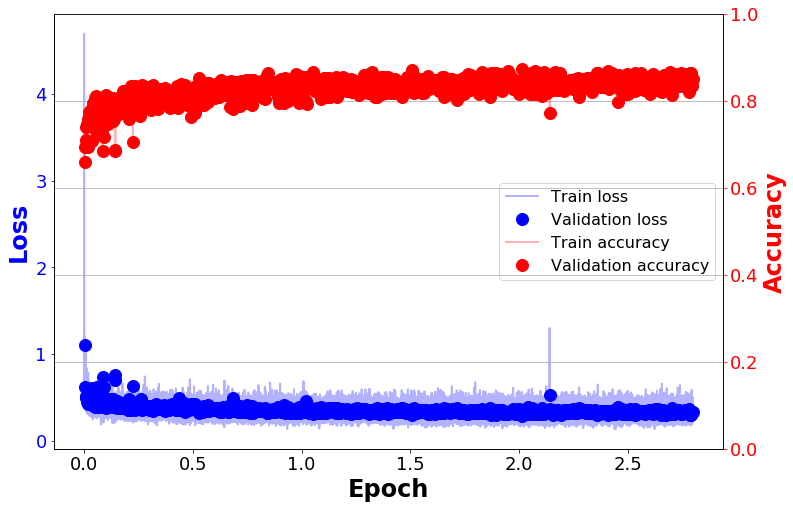

In [15]:
disp_learn_hist(blob.train_log, blob.val_log)

We see the loss is coming down while the accuracy is increasing. These two should be anti-correlated, so this is expected. We also see the network performance on the test dataset (circles) follow those of train dataset (lines). This means there is no apparent overtraining.

**Question: is the network still learning?**
Both the loss and accuracy curve have large fluctuations and it is somewhat hard to see if the values are still changing. Let's plot the moving average of the loss and accuracy values.

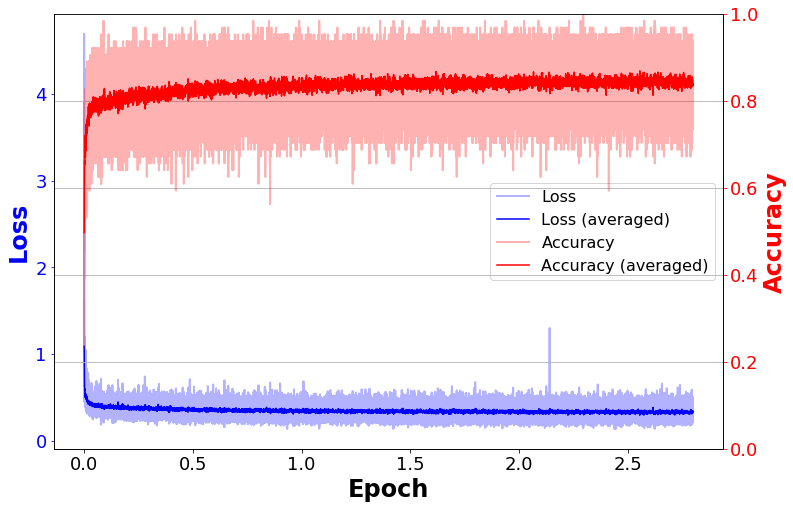

In [16]:
disp_train_smoothed(blob.train_log, blob.val_log)

The tick lines now represent the moving average (all data points are from the train log). It appears the network is still learning. We can train for a longer period to achieve a better accuracy.

## Performance Analysis
Beyond looking at the performance of the network, we can analyze how the network is performing for each classification target. Let's first obtain a high-statistics analysis output by running the network on all test samples.

First load the stored model

In [17]:
restore_state("snapshots_1M_resnet50_BS64/snapshot_best_75600.ckpt",blob)

In [18]:
# blob.data,blob.label = next(iter(test_loader))[0:2]

In [19]:
# res=forward(blob,False)

In [31]:
def inference(blob,data_loader):
    label,prediction,accuracy=[],[],[]
    # set the network to test (non-train) mode
    blob.net.eval()
    # create the result holder
    index,label,prediction, energy = [],[],[],[]
    for i,data in enumerate(data_loader):
        if i%10==0:
            print("iteration {}".format(i))
        blob.data, blob.label, energies = data[0:3]
        #print('energies: (shape is {})'.format(energies.shape))
        elist=[]
        for earr in energies:
            elist.append(np.sum(earr))
            
        energies=np.array(elist)
        #print(energies)
        #print('labels:')
        #print(blob.label)
        res = forward(blob,False)
        accuracy.append(res['accuracy'])
        prediction.append(res['prediction'])
        label.append(blob.label)
        energy.append(elist)
        #if i==2: break
    # report accuracy
    accuracy   = np.array(accuracy,dtype=np.float32)
    label      = np.hstack(label)
    prediction = np.hstack(prediction)
    energy     = np.hstack(energy)
    
    return accuracy, label, prediction, energy

Let's run the inference using this function on the test sample, and look at the error matrix.

iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 110
iteration 120
iteration 130
iteration 140
iteration 150
iteration 160
iteration 170
iteration 180
iteration 190
iteration 200
iteration 210
iteration 220
iteration 230
iteration 240
iteration 250
iteration 260
iteration 270
iteration 280
iteration 290
Accuracy mean 0.83636206 std 0.0114740655


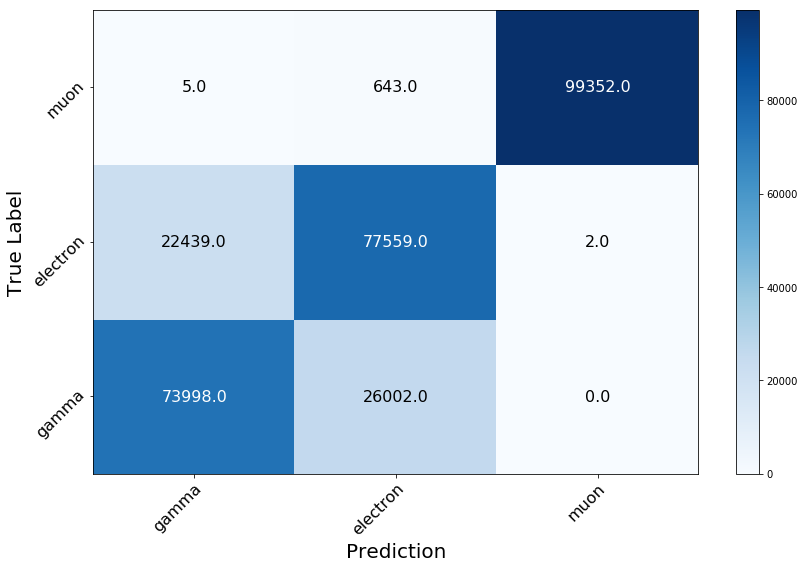

In [32]:
from utils import plot_confusion_matrix
accuracy,label,prediction,energy = inference(blob,test_loader)
print('Accuracy mean',accuracy.mean(),'std',accuracy.std())
plot_confusion_matrix(label,prediction,['gamma','electron','muon'])

As one may expect, muon is distinguished fairly well while there is some confusion between electron and gamma ray.

In [33]:
print(energy)

[ 621.2534 1467.2114 1664.6299 ... 1463.7789 1807.3488 1618.1632]


In [ ]:
import matplotlib.pyplot as plt
